In [17]:
import sys
print(sys.version)
print(sys.path)

3.7.1 | packaged by conda-forge | (default, Mar 13 2019, 13:32:59) [MSC v.1900 64 bit (AMD64)]
['D:\\michele\\jennifer', 'D:\\michele\\miniconda3\\envs\\prediction\\python37.zip', 'D:\\michele\\miniconda3\\envs\\prediction\\DLLs', 'D:\\michele\\miniconda3\\envs\\prediction\\lib', 'D:\\michele\\miniconda3\\envs\\prediction', '', 'D:\\michele\\miniconda3\\envs\\prediction\\lib\\site-packages', 'D:\\michele\\miniconda3\\envs\\prediction\\lib\\site-packages\\xgboost-0.83.dev0-py3.7.egg', 'D:\\michele\\miniconda3\\envs\\prediction\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\mtinti\\.ipython']


In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msn
from scipy import stats
from scipy.spatial import distance
import re
from sklearn import cluster
from sklearn.metrics import  silhouette_score
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.stats.multitest as smm
from sklearn.decomposition import PCA
import seaborn as sns
from statsmodels.sandbox.stats.multicomp import multipletests
plt.style.use('ggplot')
from scipy.stats import ttest_ind
#from plotly.widgets import GraphWidget
from adjustText import adjust_text
import warnings
warnings.filterwarnings("ignore")

from ipywidgets import widgets
from IPython.display import display
from plotly.widgets import GraphWidget
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.plotly as py
from plotly import tools
init_notebook_mode(connected=True)

In [19]:
path = 'D:/michele/jennifer/indata/Hypothalamus/combined/txt/proteinGroups.txt'
df = pd.read_table(path)
df.head()
print(df.shape)
df = df[df['Only identified by site']!='+']
df = df[df['Potential contaminant']!='+']
df = df[df['Reverse']!='+']
print(df.shape)

(7719, 124)
(7415, 124)


In [20]:
hippo_cols = ['Reporter intensity corrected {} Hypothalamus'.format(n) for n in range(1,11)]
hippo_df=df[hippo_cols]
hippo_df.head(10)

,Reporter intensity corrected 1 Hypothalamus,Reporter intensity corrected 2 Hypothalamus,Reporter intensity corrected 3 Hypothalamus,Reporter intensity corrected 4 Hypothalamus,Reporter intensity corrected 5 Hypothalamus,Reporter intensity corrected 6 Hypothalamus,Reporter intensity corrected 7 Hypothalamus,Reporter intensity corrected 8 Hypothalamus,Reporter intensity corrected 9 Hypothalamus,Reporter intensity corrected 10 Hypothalamus
144,48229.0,54599.0,37258.0,33234.0,5241.4,70258.0,67197.0,50585.0,50044.0,23909.0
145,17337.0,17854.0,15194.0,14568.0,10197.0,17639.0,24198.0,15684.0,19584.0,6446.0
146,528110.0,538980.0,451470.0,428220.0,416790.0,505980.0,805400.0,483620.0,591570.0,237670.0
147,296380.0,319230.0,264040.0,247620.0,164990.0,301000.0,463390.0,293720.0,345080.0,124010.0
148,7623.7,8644.8,7007.2,6378.0,4035.8,7605.4,12413.0,6262.6,8306.6,3587.9
149,503080.0,528300.0,427180.0,429350.0,508440.0,504430.0,744060.0,465770.0,559230.0,256750.0
150,111100.0,112010.0,99685.0,110620.0,98225.0,114920.0,164180.0,100140.0,125030.0,49148.0
151,20155.0,22470.0,23002.0,23496.0,7794.8,24296.0,28731.0,15937.0,27680.0,7351.1
152,20932.0,21140.0,19975.0,17731.0,11854.0,20952.0,33553.0,19225.0,22307.0,8140.7
153,30390.0,28670.0,28617.0,30818.0,19586.0,30996.0,39022.0,24002.0,34337.0,13870.0


In [21]:
hippo_df = hippo_df.replace(0, np.nan)
hippo_df.dropna(how='all', axis=0,inplace=True)
#hippo_df.head(10)

In [22]:
hippo_df.columns = ['ND_1','ND_2','ND_3','HF_1','HF_2','HF_3','KO_1','KO_2','KO_3','null']
del hippo_df['null']
#hippo_df.head(10)

In [23]:
#np.log2(hippo_df).describe()

In [24]:
#np.log2(hippo_df).plot(kind='box')

In [25]:
#np.log2(hippo_df).plot(kind='kde')

In [26]:
col_sum = hippo_df.sum(axis=0)
target = np.mean(col_sum)
norm_facs = target / col_sum
norm_facs

ND_1    1.024327
ND_2    1.029554
ND_3    1.147368
HF_1    1.115439
HF_2    0.975706
HF_3    1.020113
KO_1    0.721371
KO_2    1.188443
KO_3    0.951007
dtype: float64

## Values Distributions

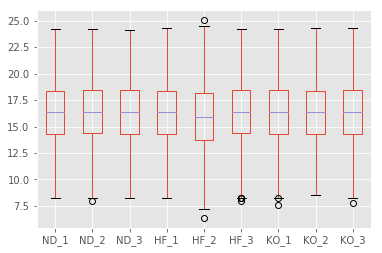

In [27]:
hippo_df = hippo_df.multiply(norm_facs,axis=1)
np.log2(hippo_df).plot(kind='box')

In [28]:
def make_pca(in_df):
    cols = in_df.columns
    pca = PCA(n_components=2)
    pca.fit(in_df)
    temp_df = pd.DataFrame()
    temp_df['pc_1']=pca.components_[0]
    temp_df['pc_2']=pca.components_[1]
    temp_df.index = cols
    print(pca.explained_variance_ratio_)
    fig,ax=plt.subplots()
    temp_df.iloc[0:3,:].plot(kind='scatter',x='pc_1',y='pc_2',s=50, c='g', ax=ax,legend ='ND')
    temp_df.iloc[3:6,:].plot(kind='scatter',x='pc_1',y='pc_2',s=50, c='b', ax=ax, legend='HF')    
    temp_df.iloc[6:9,:].plot(kind='scatter',x='pc_1',y='pc_2',s=50, c='r', ax=ax, legend='KO')
    for i, txt in enumerate(cols):
        ax.annotate(txt, (temp_df['pc_1'].values[i]+0.0003,temp_df['pc_2'].values[i]))
    #ax.set_xlabel('PC1({})'.format(round(pca.explained_variance_ratio_[0],2)))
    #ax.set_ylabel('PC2({})'.format(round(pca.explained_variance_ratio_[1],2)))
    #ax.set_xlim(0.345,0.360)
    ax.set_xlabel('PC1_{:.3f}'.format(pca.explained_variance_ratio_[0]))
    ax.set_ylabel('PC2_{:.3f}'.format(pca.explained_variance_ratio_[1]))
    
    ax.yaxis.label.set_size(12)
    ax.xaxis.label.set_size(12)
    #plt.tick_params(axis='both', which='major', labelsize=16, rotation=70, horizontalalignment='right' )
    #plt.setp( axs[1].xaxis.get_majorticklabels(), )
    fig.savefig('fig_Hypothalamus/Hippocampus_pca.svg')
    fig.savefig('fig_Hypothalamus/Hippocampus_pca.png')
    fig.savefig('fig_Hypothalamus/Hippocampus_pca.pdf')
    plt.legend()
    plt.show()

## PCA plot

[0.98251615 0.00821505]


No handles with labels found to put in legend.


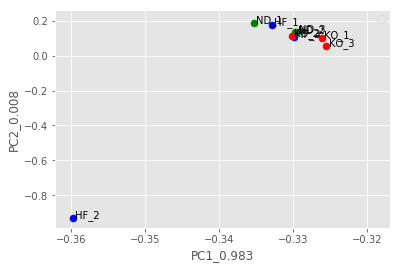

In [29]:
hippo_df=hippo_df.fillna(0)
make_pca(np.log1p(hippo_df))

In [30]:
onesample_results = ttest_ind(hippo_df[['ND_1','ND_2','ND_3']].T, 
                              hippo_df[['KO_1','KO_2','KO_3']].T)
#print(onesample_results)
hippo_df['ND_KO_pvalue']=onesample_results.pvalue
hippo_df['ND_KO_pvalue_corr']=multipletests(onesample_results.pvalue,method='bonferroni')[1]

onesample_results = ttest_ind(hippo_df[['HF_1','HF_2','HF_3']].T, 
                              hippo_df[['KO_1','KO_2','KO_3']].T)
#print(onesample_results)
hippo_df['HF_KO_pvalue']=onesample_results.pvalue
hippo_df['HF_KO_pvalue_corr']=multipletests(onesample_results.pvalue,method='bonferroni')[1]

onesample_results = ttest_ind(hippo_df[['HF_1','HF_2','HF_3']].T, 
                              hippo_df[['ND_1','ND_2','ND_3']].T)
#print(onesample_results)
hippo_df['HF_ND_pvalue']=onesample_results.pvalue
hippo_df['HF_ND_pvalue_corr']=multipletests(onesample_results.pvalue,method='bonferroni')[1]


hippo_df['log10_ND_KO_pvalue']=-np.log10(hippo_df['ND_KO_pvalue'])
hippo_df['log10_HF_KO_pvalue']=-np.log10(hippo_df['HF_KO_pvalue'])
hippo_df['log10_HF_ND_pvalue']=-np.log10(hippo_df['HF_ND_pvalue'])
hippo_df.head()

,ND_1,ND_2,ND_3,HF_1,HF_2,HF_3,KO_1,KO_2,KO_3,ND_KO_pvalue,ND_KO_pvalue_corr,HF_KO_pvalue,HF_KO_pvalue_corr,HF_ND_pvalue,HF_ND_pvalue_corr,log10_ND_KO_pvalue,log10_HF_KO_pvalue,log10_HF_ND_pvalue
144,49402.252073,56212.629307,42748.632262,37070.496418,5114.067406,71671.078649,48473.957489,60117.370064,47592.172868,0.665988,1.0,0.512192,1.0,0.588954,1.0,0.176533,0.290567,0.229919
145,17758.751875,18381.660537,17433.107483,16249.713902,9949.277930,17993.768059,17455.732002,18639.534093,18624.512698,0.471304,1.0,0.229157,1.0,0.272423,1.0,0.326699,0.639867,0.564756
146,540957.169796,554909.118191,518002.174230,477653.245955,406664.661030,516156.628065,580992.088365,574754.621144,562586.957550,0.044469,1.0,0.031137,1.0,0.103311,1.0,1.351947,1.506718,0.985855
147,303589.945246,328664.584586,302951.013542,276204.980532,160981.795205,307053.925150,334276.041504,349069.367112,328173.347721,0.072487,1.0,0.118114,1.0,0.232239,1.0,1.139742,0.927700,0.634064
148,7809.159409,8900.290076,8039.836169,7114.269307,3937.755798,7758.365190,8954.376450,7442.740768,7899.631187,0.800035,1.0,0.221163,1.0,0.181873,1.0,0.096891,0.655288,0.740233


In [31]:
#for visualization later
hippo_df['mean_ND'] = hippo_df[['ND_1','ND_2','ND_3']].median(axis=1)
hippo_df['mean_HF'] = hippo_df[['HF_1','HF_2','HF_3']].median(axis=1)
hippo_df['mean_KO'] = hippo_df[['KO_1','KO_2','KO_3']].median(axis=1)

hippo_df['log2_fc_HF_ND'] = np.log2(hippo_df['mean_HF']/hippo_df['mean_ND'])
hippo_df['log2_fc_ND_KO'] = np.log2(hippo_df['mean_ND']/hippo_df['mean_KO'])
hippo_df['log2_fc_HF_KO'] = np.log2(hippo_df['mean_HF']/hippo_df['mean_KO'])


## p-values distridibutions

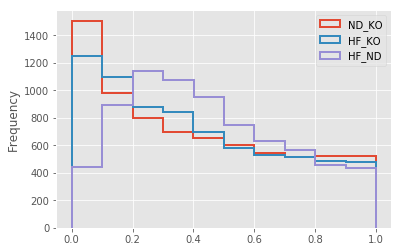

In [32]:
hippo_df['ND_KO_pvalue'].plot(kind='hist',bins=10,histtype='step',label='ND_KO',linewidth=2)
hippo_df['HF_KO_pvalue'].plot(kind='hist',bins=10,histtype='step',label='HF_KO',linewidth=2)
hippo_df['HF_ND_pvalue'].plot(kind='hist',bins=10,histtype='step',label='HF_ND',linewidth=2)
plt.legend()
plt.show()

bace_index 1417


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


208     tr|A2CEK9|A2CEK9_MOUSE Major urinary protein 1...
763     sp|P07759|SPA3K_MOUSE Serine protease inhibito...
2804    tr|F7CW61|F7CW61_MOUSE All-trans-retinol 13,14...
4321    sp|Q8K1L5|PP1RB_MOUSE E3 ubiquitin-protein lig...
6775    sp|Q9Z2H5|E41L1_MOUSE Band 4.1-like protein 1 ...
7192    tr|D3YXM0|D3YXM0_MOUSE Signal-regulatory prote...
Name: Fasta headers, dtype: object

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


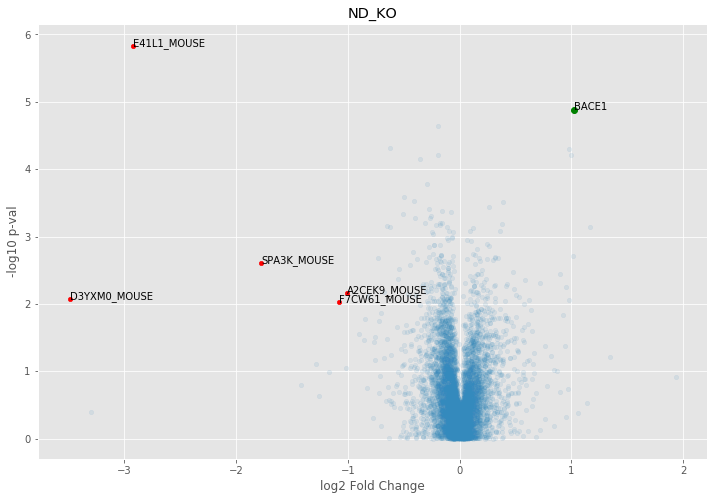

In [33]:
def find_sprot(index, series, sprot_id):
    for index,n in zip(index, series):
        if sprot_id in n:
            return index
    return -1


bace_index = find_sprot(df.index.values, df['Fasta headers'],'P56818')
print('bace_index', bace_index)
tag = 'ND_KO'

fig,ax=plt.subplots(figsize=(12,8))
hippo_df.plot(kind='scatter',
             x='log2_fc_{}'.format(tag),
             y='log10_{}_pvalue'.format(tag), 
             ax=ax, alpha=0.1)

hippo_df[(hippo_df['{}_pvalue'.format(tag)]<0.05) & 
         (hippo_df['log2_fc_{}'.format(tag)]<-1)].plot(kind='scatter',
             x='log2_fc_{}'.format(tag),
             y='log10_{}_pvalue'.format(tag), 
             ax=ax, c='r')

select = hippo_df[(hippo_df['{}_pvalue'.format(tag)]<0.05) & 
         (hippo_df['log2_fc_{}'.format(tag)]<-1)]

ax.plot(hippo_df.loc[bace_index]['log2_fc_{}'.format(tag)],
        hippo_df.loc[bace_index]['log10_{}_pvalue'.format(tag)],marker='o', c='g')

plt.text(hippo_df.loc[bace_index]['log2_fc_{}'.format(tag)],
         hippo_df.loc[bace_index]['log10_{}_pvalue'.format(tag)],
        'BACE1')

texts = [plt.text(select.loc[i]['log2_fc_{}'.format(tag)], 
                  select.loc[i]['log10_{}_pvalue'.format(tag)], 
                  df.loc[i]['Fasta headers'].split('|')[2].split(';')[0].split(' ')[0]) for i in select.index.values]


plt.xlabel('log2 Fold Change')
plt.ylabel('-log10 p-val')
plt.title(tag)
#adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
genes = df.loc[select.index.values]['Fasta headers']
fig.savefig('fig_Hypothalamus/Hypothalamus_ND_KO.svg')
fig.savefig('fig_Hypothalamus/Hypothalamus_ND_KO.png')
fig.savefig('fig_Hypothalamus/Hypothalamus_ND_KO.pdf')
genes

In [34]:

#interactive plot
trace_1 = go.Scatter(
    x=hippo_df['log2_fc_{}'.format(tag)],
    y=hippo_df['log10_{}_pvalue'.format(tag)],
    mode='markers',
    name='MA Plot',
    text = [df.loc[i]['Fasta headers'].split('|')[2].split(';')[0].split(' ')[0] for i in hippo_df.index.values],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = hippo_df['log10_{}_pvalue'.format(tag)], #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)


annot_1 = go.Scatter(
    x=[hippo_df.loc[bace_index]['log2_fc_{}'.format(tag)]],
    y=[hippo_df.loc[bace_index]['log10_{}_pvalue'.format(tag)]],
    mode='markers+text',
    name='BACE1',
    text=['BACE1'],
    textposition='bottom center'
)
layout = dict(title=tag,
             width=800,
             height=800,
              
             )

fig = go.Figure(data=[trace_1,annot_1], 
                layout=layout)
iplot(fig, filename='test')

In [35]:
#significant after
#bonferroni correction
df.loc[hippo_df[hippo_df['ND_KO_pvalue_corr']<0.05].index.values]

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Phospho (STY) site IDs,Oxidation (M) site positions,Phospho (STY) site positions
6775,sp|Q9Z2H5|E41L1_MOUSE;tr|A0A2R8VHB6|A0A2R8VHB6...,sp|Q9Z2H5|E41L1_MOUSE,44;8,5;0,5;0,sp|Q9Z2H5|E41L1_MOUSE Band 4.1-like protein 1 ...,2,44,5,5,...,1002;1830;3856;7823;8684;9631;11126;11399;1149...,False;False;True;False;True;False;False;True;F...,1051;1944;1945;4075;8255;9162;9163;10172;11757...,2543;2544;4473;4474;4475;4476;4477;4478;8801;8...,2857;2858;5021;5022;5023;5024;5025;5026;5027;9...,2857;5023;9939;19781;22012;24369;28130;28889;2...,2343;2344;2345;2346;2347;2348;2349,1957;1958;1959;1960;1961;1962;1963;1964;1965;2...,63;264;389;688;699;734;767,378;430;475;510;639;648;650;652;677;684;685;868


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


208     tr|A2CEK9|A2CEK9_MOUSE Major urinary protein 1...
226     sp|A6H6E2|MMRN2_MOUSE Multimerin-2 OS=Mus musc...
763     sp|P07759|SPA3K_MOUSE Serine protease inhibito...
1899    sp|Q00898|A1AT5_MOUSE Alpha-1-antitrypsin 1-5 ...
2736    sp|Q62507|COCH_MOUSE Cochlin OS=Mus musculus O...
4321    sp|Q8K1L5|PP1RB_MOUSE E3 ubiquitin-protein lig...
4891    tr|A2AC16|A2AC16_MOUSE Dicarbonyl L-xylulose r...
6025    sp|Q9DCA5|BRX1_MOUSE Ribosome biogenesis prote...
6775    sp|Q9Z2H5|E41L1_MOUSE Band 4.1-like protein 1 ...
7192    tr|D3YXM0|D3YXM0_MOUSE Signal-regulatory prote...
7675    tr|Q91XW9|Q91XW9_MOUSE MCG133388, isoform CRA_...
Name: Fasta headers, dtype: object

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


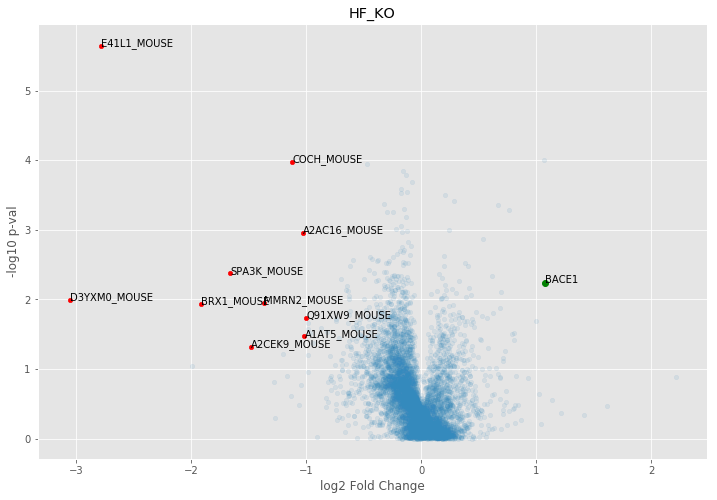

In [36]:
tag = 'HF_KO'

fig,ax=plt.subplots(figsize=(12,8))
hippo_df.plot(kind='scatter',
             x='log2_fc_{}'.format(tag),
             y='log10_{}_pvalue'.format(tag), 
             ax=ax, alpha=0.1)

hippo_df[(hippo_df['{}_pvalue'.format(tag)]<0.05) & 
         (hippo_df['log2_fc_{}'.format(tag)]<-1)].plot(kind='scatter',
             x='log2_fc_{}'.format(tag),
             y='log10_{}_pvalue'.format(tag), 
             ax=ax, c='r')

select = hippo_df[(hippo_df['{}_pvalue'.format(tag)]<0.05) & 
         (hippo_df['log2_fc_{}'.format(tag)]<-1)]

ax.plot(hippo_df.loc[bace_index]['log2_fc_{}'.format(tag)],
        hippo_df.loc[bace_index]['log10_{}_pvalue'.format(tag)],marker='o', c='g')

plt.text(hippo_df.loc[bace_index]['log2_fc_{}'.format(tag)],
         hippo_df.loc[bace_index]['log10_{}_pvalue'.format(tag)],
        'BACE1')

texts = [plt.text(select.loc[i]['log2_fc_{}'.format(tag)], 
                  select.loc[i]['log10_{}_pvalue'.format(tag)], 
                  df.loc[i]['Fasta headers'].split('|')[2].split(';')[0].split(' ')[0]) for i in select.index.values]


plt.xlabel('log2 Fold Change')
plt.ylabel('-log10 p-val')
plt.title(tag)
#adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
genes = df.loc[select.index.values]['Fasta headers']
fig.savefig('fig_Hypothalamus/Hypothalamus_HF_KO.svg')
fig.savefig('fig_Hypothalamus/Hypothalamus_HF_KO.png')
fig.savefig('fig_Hypothalamus/Hypothalamus_HF_KO.pdf')
genes

In [37]:

#interactive plot
trace_1 = go.Scatter(
    x=hippo_df['log2_fc_{}'.format(tag)],
    y=hippo_df['log10_{}_pvalue'.format(tag)],
    mode='markers',
    name='MA Plot',
    text = [df.loc[i]['Fasta headers'].split('|')[2].split(';')[0].split(' ')[0] for i in hippo_df.index.values],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = hippo_df['log10_{}_pvalue'.format(tag)], #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)


annot_1 = go.Scatter(
    x=[hippo_df.loc[bace_index]['log2_fc_{}'.format(tag)]],
    y=[hippo_df.loc[bace_index]['log10_{}_pvalue'.format(tag)]],
    mode='markers+text',
    name='BACE1',
    text=['BACE1'],
    textposition='bottom center'
)
layout = dict(title=tag,
             width=800,
             height=800,
              
             )

fig = go.Figure(data=[trace_1,annot_1], 
                layout=layout)
iplot(fig, filename='test')

In [38]:
#significant
#bonferroni correction
df.loc[hippo_df[hippo_df['HF_KO_pvalue_corr']<0.05].index.values]

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Phospho (STY) site IDs,Oxidation (M) site positions,Phospho (STY) site positions
6775,sp|Q9Z2H5|E41L1_MOUSE;tr|A0A2R8VHB6|A0A2R8VHB6...,sp|Q9Z2H5|E41L1_MOUSE,44;8,5;0,5;0,sp|Q9Z2H5|E41L1_MOUSE Band 4.1-like protein 1 ...,2,44,5,5,...,1002;1830;3856;7823;8684;9631;11126;11399;1149...,False;False;True;False;True;False;False;True;F...,1051;1944;1945;4075;8255;9162;9163;10172;11757...,2543;2544;4473;4474;4475;4476;4477;4478;8801;8...,2857;2858;5021;5022;5023;5024;5025;5026;5027;9...,2857;5023;9939;19781;22012;24369;28130;28889;2...,2343;2344;2345;2346;2347;2348;2349,1957;1958;1959;1960;1961;1962;1963;1964;1965;2...,63;264;389;688;699;734;767,378;430;475;510;639;648;650;652;677;684;685;868


6025    sp|Q9DCA5|BRX1_MOUSE Ribosome biogenesis prote...
7370    tr|E9QAE3|E9QAE3_MOUSE B-TFIID TATA-box-bindin...
Name: Fasta headers, dtype: object

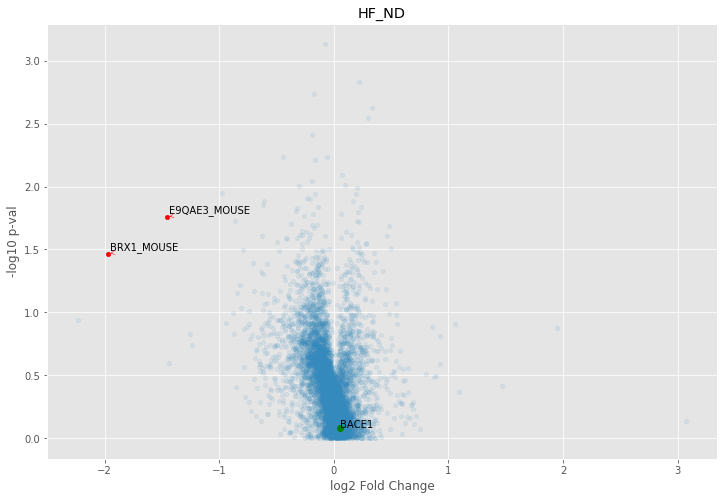

In [39]:
tag = 'HF_ND'

fig,ax=plt.subplots(figsize=(12,8))
hippo_df.plot(kind='scatter',
             x='log2_fc_{}'.format(tag),
             y='log10_{}_pvalue'.format(tag), 
             ax=ax, alpha=0.1)

hippo_df[(hippo_df['{}_pvalue'.format(tag)]<0.05) & 
         (hippo_df['log2_fc_{}'.format(tag)]<-1)].plot(kind='scatter',
             x='log2_fc_{}'.format(tag),
             y='log10_{}_pvalue'.format(tag), 
             ax=ax, c='r')

select = hippo_df[(hippo_df['{}_pvalue'.format(tag)]<0.05) & 
         (hippo_df['log2_fc_{}'.format(tag)]<-1)]

ax.plot(hippo_df.loc[bace_index]['log2_fc_{}'.format(tag)],
        hippo_df.loc[bace_index]['log10_{}_pvalue'.format(tag)],marker='o', c='g')

plt.text(hippo_df.loc[bace_index]['log2_fc_{}'.format(tag)],
         hippo_df.loc[bace_index]['log10_{}_pvalue'.format(tag)],
        'BACE1')

texts = [plt.text(select.loc[i]['log2_fc_{}'.format(tag)], 
                  select.loc[i]['log10_{}_pvalue'.format(tag)], 
                  df.loc[i]['Fasta headers'].split('|')[2].split(';')[0].split(' ')[0]) for i in select.index.values]


plt.xlabel('log2 Fold Change')
plt.ylabel('-log10 p-val')
plt.title(tag)
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
genes = df.loc[select.index.values]['Fasta headers']
fig.savefig('fig_Hypothalamus/Hypothalamus_HF_ND.svg')
fig.savefig('fig_Hypothalamus/Hypothalamus_HF_ND.png')
fig.savefig('fig_Hypothalamus/Hypothalamus_HF_ND.pdf')
genes

In [40]:
#significant after
#bonferroni correction
df.loc[hippo_df[hippo_df['HF_ND_pvalue_corr']<0.05].index.values]

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Phospho (STY) site IDs,Oxidation (M) site positions,Phospho (STY) site positions


In [41]:
hippo_df.to_csv('Hypothalamus.csv')

In [42]:
df = pd.read_table('D:/michele/jennifer/indata/Hypothalamus/combined/txt/evidence.txt')
df.head()

,Sequence,Length,Modifications,Modified sequence,Oxidation (M) Probabilities,Phospho (STY) Probabilities,Oxidation (M) Score Diffs,Phospho (STY) Score Diffs,Acetyl (Protein N-term),Oxidation (M),...,Potential contaminant,id,Protein group IDs,Peptide ID,Mod. peptide ID,MS/MS IDs,Best MS/MS,AIF MS/MS IDs,Oxidation (M) site IDs,Phospho (STY) site IDs
0,AAAAAAAAAAAAAAAGAAGK,20,Unmodified,_AAAAAAAAAAAAAAAGAAGK_,NaN,NaN,NaN,NaN,0,0,...,NaN,0,7378,0,0,0,0,NaN,NaN,NaN
1,AAAAAAAAAAGAAGGR,16,Acetyl (Protein N-term),_(ac)AAAAAAAAAAGAAGGR_,NaN,NaN,NaN,NaN,1,0,...,NaN,1,4111,1,1,1,1,NaN,NaN,NaN
2,AAAAAAAAAAGAAGGR,16,Acetyl (Protein N-term),_(ac)AAAAAAAAAAGAAGGR_,NaN,NaN,NaN,NaN,1,0,...,NaN,2,4111,1,1,2,2,NaN,NaN,NaN
3,AAAAAAAAVGDPQPPQPEAPAQGLALDK,28,Acetyl (Protein N-term),_(ac)AAAAAAAAVGDPQPPQPEAPAQGLALDK_,NaN,NaN,NaN,NaN,1,0,...,NaN,3,2457,2,2,3,3,NaN,NaN,NaN
4,AAAAAAGAASGLPGPVAQGLK,21,Acetyl (Protein N-term),_(ac)AAAAAAGAASGLPGPVAQGLK_,NaN,NaN,NaN,NaN,1,0,...,NaN,4,4918,3,3,4,4,NaN,NaN,NaN


In [43]:
df = df[df['Reverse']!='+']
df = df[df['Potential contaminant']!='+']
#df['Fraction'].value_counts()
temp = df[['Sequence','Proteins']]
temp.drop_duplicates(subset=['Sequence'],inplace=True)
temp.set_index('Sequence',inplace=True)
pep_to_prot = temp.to_dict()

In [44]:
data=df[['Sequence', 'Experiment',
       'Reporter intensity corrected 1', 'Reporter intensity corrected 2',
       'Reporter intensity corrected 3', 'Reporter intensity corrected 4',
       'Reporter intensity corrected 5', 'Reporter intensity corrected 6',
       'Reporter intensity corrected 7', 'Reporter intensity corrected 8',
       'Reporter intensity corrected 9']]

In [45]:
res = data.groupby(['Sequence', 'Experiment']).sum().unstack()
res.columns = [n[0] + ' '+ n[1] for n in res.columns]
res.replace(0,np.nan,inplace=True)
#res.dropna(inplace=True)
res.head()

,Reporter intensity corrected 1 Hypothalamus,Reporter intensity corrected 2 Hypothalamus,Reporter intensity corrected 3 Hypothalamus,Reporter intensity corrected 4 Hypothalamus,Reporter intensity corrected 5 Hypothalamus,Reporter intensity corrected 6 Hypothalamus,Reporter intensity corrected 7 Hypothalamus,Reporter intensity corrected 8 Hypothalamus,Reporter intensity corrected 9 Hypothalamus
Sequence,,,,,,,,,
AAAAAAAAAAAAAAAGAAGK,27559.00,40018.00,28022.00,32625.00,30973.00,29974.00,40952.00,21994.00,42758.00
AAAAAAAAAAGAAGGR,2138.73,1969.98,1571.46,2032.94,1635.04,2287.83,2247.11,1696.33,2510.76
AAAAAAAAVGDPQPPQPEAPAQGLALDK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAAAAAGAASGLPGPVAQGLK,13676.70,15198.40,15162.90,12325.40,15991.60,17166.60,25104.60,16729.10,18807.70
AAAAAAGPEMVR,40813.10,78552.40,59828.90,90789.00,83964.50,68429.40,70391.30,54592.30,83860.80


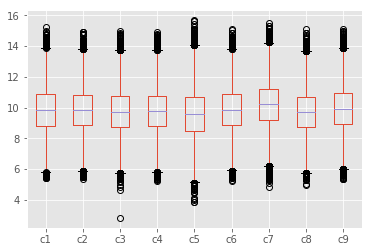

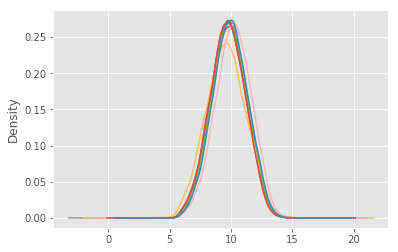

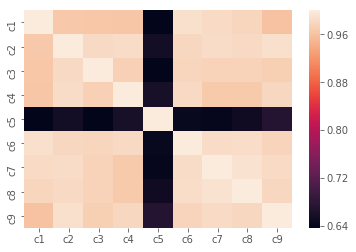

In [46]:
Hippo = res.copy()
#Hippo.dropna(inplace=True)
Hippo.columns = ['c'+str(n) for n in range(1,10)]
np.log1p(Hippo).plot(kind='box')
plt.show()
np.log1p(Hippo).plot(kind='kde',legend=False)
plt.show()
sns.heatmap(Hippo.corr())
plt.show()

In [47]:
temp = pd.DataFrame()
temp['exp1']=Hippo.sum(axis=0, skipna=True)
temp['target']=temp['exp1'].mean()
temp['n1'] = temp.target / temp.exp1
temp.head()

,exp1,target,n1
c1,2.883825e+09,2.953872e+09,1.024290
c2,2.869992e+09,2.953872e+09,1.029227
c3,2.577821e+09,2.953872e+09,1.145879
c4,2.652710e+09,2.953872e+09,1.113530
c5,3.014245e+09,2.953872e+09,0.979971


In [48]:
Hippo_sl = Hippo.multiply(temp['n1'].values)
Hippo_sl.head()

,c1,c2,c3,c4,c5,c6,c7,c8,c9
Sequence,,,,,,,,,
AAAAAAAAAAAAAAAGAAGK,28228.398593,41187.586181,32109.834274,36328.916104,30352.640439,30547.129305,29537.969783,26147.278176,40639.864720
AAAAAAAAAAGAAGGR,2190.679013,2027.555626,1800.703739,2263.739669,1602.291713,2331.575327,1620.801604,2016.659652,2386.382589
AAAAAAAAVGDPQPPQPEAPAQGLALDK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAAAAAGAASGLPGPVAQGLK,14008.902320,15642.596077,17374.855689,13724.702607,15671.303549,17494.840526,18107.514070,19888.170925,17876.008787
AAAAAAGPEMVR,41804.436105,80848.211923,68556.707721,101096.274764,82282.771385,69737.830454,50772.028041,64901.339200,79706.524331


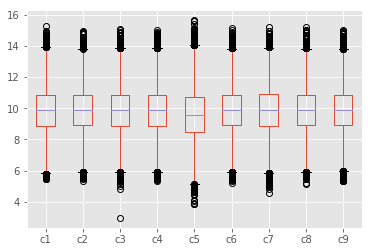

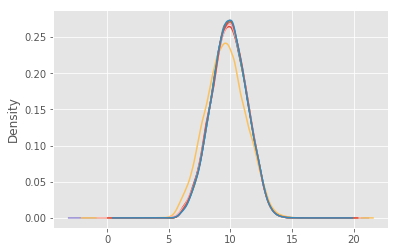

In [49]:
np.log1p(Hippo_sl).plot(kind='box')
plt.show()
np.log1p(Hippo_sl).plot(kind='kde',legend=False)
plt.show()

In [50]:
irs = Hippo_sl.sum(axis=1).to_frame()
irs.columns=['sum']
Hippo_sl = Hippo_sl.divide(irs['sum'].values, axis='index')
Hippo_sl.head()

,c1,c2,c3,c4,c5,c6,c7,c8,c9
Sequence,,,,,,,,,
AAAAAAAAAAAAAAAGAAGK,0.095664,0.139581,0.108818,0.123116,0.102863,0.103522,0.100102,0.088611,0.137725
AAAAAAAAAAGAAGGR,0.120100,0.111157,0.098721,0.124106,0.087843,0.127825,0.088858,0.110560,0.130830
AAAAAAAAVGDPQPPQPEAPAQGLALDK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAAAAAGAASGLPGPVAQGLK,0.093524,0.104431,0.115996,0.091627,0.104623,0.116797,0.120887,0.132775,0.119341
AAAAAAGPEMVR,0.065349,0.126383,0.107169,0.158035,0.128626,0.109015,0.079368,0.101455,0.124599


In [51]:
Hippo_sl['prot']=[pep_to_prot['Proteins'][n] for n in Hippo_sl.index.values]
Hippo_sl.head()

,c1,c2,c3,c4,c5,c6,c7,c8,c9,prot
Sequence,,,,,,,,,,
AAAAAAAAAAAAAAAGAAGK,0.095664,0.139581,0.108818,0.123116,0.102863,0.103522,0.100102,0.088611,0.137725,tr|E9QM38|E9QM38_MOUSE;sp|P55012|S12A2_MOUSE
AAAAAAAAAAGAAGGR,0.120100,0.111157,0.098721,0.124106,0.087843,0.127825,0.088858,0.110560,0.130830,sp|Q8CCS6|PABP2_MOUSE;tr|G3UY42|G3UY42_MOUSE;t...
AAAAAAAAVGDPQPPQPEAPAQGLALDK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sp|Q5U430|UBR3_MOUSE;tr|F6QC57|F6QC57_MOUSE
AAAAAAGAASGLPGPVAQGLK,0.093524,0.104431,0.115996,0.091627,0.104623,0.116797,0.120887,0.132775,0.119341,tr|E9QKZ2|E9QKZ2_MOUSE;sp|Q91YE6|IPO9_MOUSE;tr...
AAAAAAGPEMVR,0.065349,0.126383,0.107169,0.158035,0.128626,0.109015,0.079368,0.101455,0.124599,sp|P63085|MK01_MOUSE


Text(0.5, 1.0, 'pep Q9Z2H5')

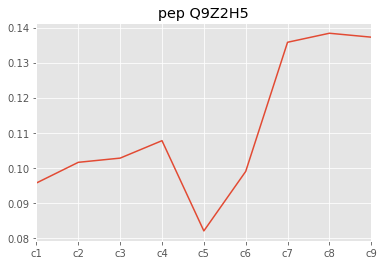

In [55]:
def find_prot(inlist, prot='Q3UGC7'):
    out = []
    for p,n in enumerate(inlist):
        if prot in n:
            out.append(p)
    return out

temp_index = find_prot(Hippo_sl['prot'].values, prot='Q9Z2H5')
Hippo_sl.iloc[temp_index].mean().plot()#.plot(kind='box',showfliers=False)
plt.title('pep Q9Z2H5')

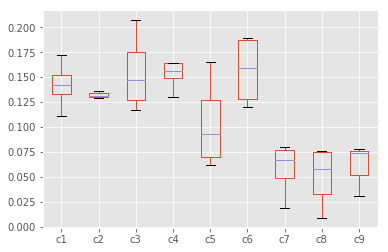

In [53]:
temp_index = find_prot(Hippo_sl['prot'].values, prot='P56818')
Hippo_sl.iloc[temp_index].plot(kind='box',showfliers=False)

In [54]:
Hippo_sl.to_csv('pep_norm_hypo.csv')